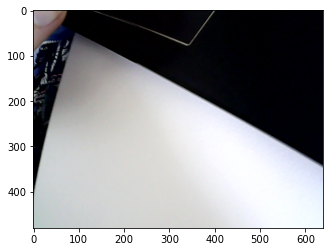

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
%matplotlib inline




# Define the range for the tennis ball color in HSV
lower_yellow_green = np.array([25, 70, 120])
upper_yellow_green = np.array([60, 255, 255])

# Start capturing video from the USB camera (usually index 1)
cap = cv2.VideoCapture(0)  # Try changing to 2, 3, etc., if 1 doesn't work

if not cap.isOpened():
    print("Error: Could not open USB camera.")
else:
    try:
        while True:
            # Capture frame-by-frame
            ret, frame = cap.read()
            if not ret:
                print("Error: Failed to capture image.")
                break

            # Convert the frame to the HSV color space
            hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

            # Create a mask for the tennis ball color
            mask = cv2.inRange(hsv, lower_yellow_green, upper_yellow_green)

            # Perform morphological operations to remove noise and improve detection
            kernel = np.ones((5, 5), np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

            # Find contours
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Track the tennis ball by finding the largest contour
            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                area = cv2.contourArea(largest_contour)
                if area > 1000:  # Adjust the area threshold as needed
                    (x, y), radius = cv2.minEnclosingCircle(largest_contour)
                    center = (int(x), int(y))
                    radius = int(radius)

                    # Draw the circle and centroid on the frame
                    cv2.circle(frame, center, radius, (0, 255, 0), 4)
                    cv2.circle(frame, center, 5, (0, 128, 255), -1)

            # Display the resulting frame
    #         cv2.imshow("Tennis Ball Tracking", frame)
            #Show the image with matplotlib
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            display.clear_output(wait=True)
            plt.imshow(frame)
            plt.show()

            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    except KeyboardInterrupt:
        # Release the webcam and close windows
        cap.release()
        cv2.destroyAllWindows()


In [1]:
# Find a valid camera indice
import os
devs = os.listdir('/dev')
vid_indices = [int(dev[-1]) for dev in devs 
               if dev.startswith('video')]
vid_indices = sorted(vid_indices)
vid_indices

[0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 4, 5, 6, 8]

In [2]:
# Test a camera indice
cap = cv2.VideoCapture(0)  # Try changing to 0, 2, 3, etc., if 1 doesn't work
lower_yellow_green = np.array([25, 70, 120])
upper_yellow_green = np.array([60, 255, 255])

if not cap.isOpened():
    print("Error: Could not open USB camera.")
else:
    print("Camera opened")
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture image.")
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
   # Create a mask for the tennis ball color
    mask = cv2.inRange(hsv, lower_yellow_green, upper_yellow_green)

    # Perform morphological operations to remove noise and improve detection
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Track the tennis ball by finding the largest contour
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)
        if area > 1000:  # Adjust the area threshold as needed
            (x, y), radius = cv2.minEnclosingCircle(largest_contour)
            center = (int(x), int(y))
            radius = int(radius)

            # Draw the circle and centroid on the frame
            cv2.circle(frame, center, radius, (0, 255, 0), 4)
            cv2.circle(frame, center, 5, (0, 128, 255), -1)
    
    cv2.imshow("Tennis Ball Tracking", frame)

    
    
    
    cap.release()
    cv2.destroyAllWindows()


NameError: name 'cv2' is not defined

In [ ]:
import numpy as np
from time import time

class TennisBallDetector:
    def __init__(self, lower_color=(20, 100, 100), upper_color=(40, 255, 255), min_radius=10, max_radius=50, min_area=1000):
        self.lower_color = np.array(lower_color)
        self.upper_color = np.array(upper_color)
        self.min_radius = min_radius
        self.max_radius = max_radius
        self.min_area = min_area
        self.balls = []
        self.frame_center = None
        self.last_scanned_time = None
        self.kernel = np.ones((5, 5), np.uint8)

    def detect(self, frame):
        self.last_scanned_time = time()
        self.frame_center = (frame.shape[1] // 2, frame.shape[0] // 2)
        
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, self.lower_color, self.upper_color)

        # Perform morphological operations
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, self.kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, self.kernel)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        self.balls = []

        for contour in contours:
            area = cv2.contourArea(contour)
            if area > self.min_area:
                ((x, y), radius) = cv2.minEnclosingCircle(contour)
                if self.min_radius < radius < self.max_radius:
                    self.balls.append(((int(x), int(y)), int(radius)))

        # Sort balls by size (largest first) if multiple balls are detected
        self.balls.sort(key=lambda ball: ball[1], reverse=True)

    def get_ball_count(self):
        return len(self.balls)

    def get_ball_locations(self):
        return [ball[0] for ball in self.balls]

    def get_ball_distance_from_center(self, ball_index):
        if 0 <= ball_index < len(self.balls):
            ball_center = self.balls[ball_index][0]
            dx = ball_center[0] - self.frame_center[0]
            dy = ball_center[1] - self.frame_center[1]
            distance_pixels = np.sqrt(dx**2 + dy**2)
            angle_radians = np.arctan2(dy, dx)
            return distance_pixels, angle_radians
        else:
            return None

    def draw_balls(self, frame):
        for i, (center, radius) in enumerate(self.balls):
            color = (0, 255, 0) if i == 0 else (0, 255, 255)  # Green for largest, Yellow for others
            cv2.circle(frame, center, radius, color, 2)
            cv2.circle(frame, center, 5, (0, 0, 255), -1)
        return frame

    def get_last_scanned_time(self):
        return self.last_scanned_time






if __name__ == "__main__":
    detector = TennisBallDetector()
    cap = cv2.VideoCapture(0)  # Use 0 for default camera

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        detector.detect(frame)
        frame = detector.draw_balls(frame)

        print(f"Number of tennis balls: {detector.get_ball_count()}")
        print(f"Ball locations: {detector.get_ball_locations()}")
        print(f"Last scanned time: {detector.get_last_scanned_time():.2f}")

        if detector.get_ball_count() > 0:
            distance, angle = detector.get_ball_distance_from_center(0)
            print(f"Distance of largest ball from center: {distance:.2f} pixels")
            print(f"Angle of largest ball from center: {angle:.2f} radians")

        cv2.imshow('Tennis Ball Detector', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()